## 02 Bounding Box Detection

- Image classification is a great starting point for deep learning, an despite it's relative simplicity, can be incredibly useful. 
- However, for many applications, it's simply not enough to know *what's* in an an image, we also need to know *where*
- One of most popular ways to both classify and localize objects in image using deep learning is with **bounding box detection models**. 
- Let's see if we can get one together!

In [1]:
import warnings, cv2, shutil, subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from utils import *

In [2]:
warnings.simplefilter('ignore') #May want to supress fastai/pytorch warnings

## 1. Data

- As usual, we'll start by getting some data. 
- We'll have to do a bit of data wrangling to get our labels into good shape

In [42]:
data_dir=Path('data/')
dataset_name='carpet'
get_mvtech_dataset(data_dir, dataset_name)

Downloading: 3% [24567808 / 740285760] bytes

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Downloading: 9% [69287936 / 740285760] bytes

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Downloading: 100% [740285760 / 740285760] bytes

In [43]:
subprocess.call(['chmod', '-R', '777', str(data_dir/dataset_name)]) #Change permissions

0

In [44]:
list((data_dir/dataset_name).glob('*'))

[PosixPath('data/carpet/test'),
 PosixPath('data/carpet/train'),
 PosixPath('data/carpet/readme.txt'),
 PosixPath('data/carpet/license.txt'),
 PosixPath('data/carpet/ground_truth')]

- Let's have a look at our labels

In [45]:
list((data_dir/dataset_name/'ground_truth').glob('*'))

[PosixPath('data/carpet/ground_truth/metal_contamination'),
 PosixPath('data/carpet/ground_truth/color'),
 PosixPath('data/carpet/ground_truth/thread'),
 PosixPath('data/carpet/ground_truth/hole'),
 PosixPath('data/carpet/ground_truth/cut')]

In [46]:
list((data_dir/dataset_name/'ground_truth'/'poke').glob('*'))[:5]

[]

- Our labels come to us in the form of segmentation masks
- let's see if we can massage these into bounding boxes :)

In [47]:
masks=list((data_dir/dataset_name/'ground_truth'/'poke').glob('*'))

In [48]:
im=cv2.imread(str(masks[0]))
plt.imshow(im)

IndexError: list index out of range

- Alright, here we have a mask!
- Let's find our corresponding image and see if it makes any sense. 

In [49]:
all_classes=[p.name for p in (data_dir/dataset_name/'test').glob('*')]

In [50]:
all_classes

['metal_contamination', 'color', 'thread', 'hole', 'good', 'cut']

In [51]:
c=all_classes[0]
im_paths={int(p.name.split('.')[0]):p for p in (data_dir/dataset_name/'test'/c).glob('*')}
mask_paths={int(p.name.split('_')[0]):p for p in (data_dir/dataset_name/'ground_truth'/c).glob('*')}

In [52]:
i=1
im=cv2.cvtColor(cv2.imread(str(im_paths[i])), cv2.COLOR_BGR2RGB)
mask=cv2.imread(str(mask_paths[i]))

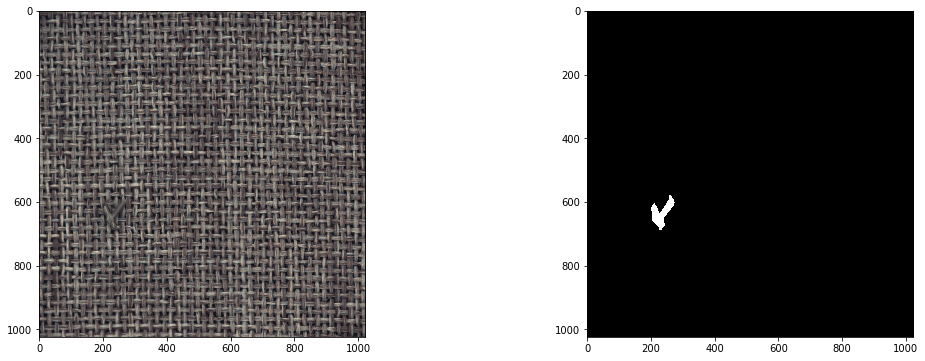

In [53]:
fig=plt.figure(0, (18,6))
fig.add_subplot(1,2,1); plt.imshow(im)
fig.add_subplot(1,2,2); plt.imshow(mask)

- Alright, now we're getting somewhere!
- Now, let's see if we can turn out mask into a bounding box.

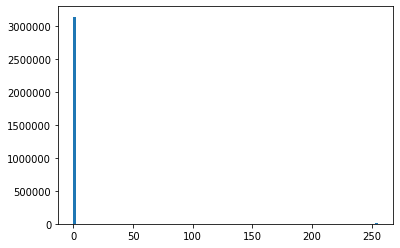

In [54]:
plt.hist(mask.ravel(), 100);

In [55]:
np.unique(mask.ravel())

array([  0, 255], dtype=uint8)

In [56]:
def mask2bbox(mask, region_value=255):
    x,y=np.where(mask==region_value)
    return [np.min(x), np.min(y), np.max(x), np.max(y)]

In [57]:
bbox=mask2bbox(mask[:,:,0]); bbox

[579, 199, 688, 274]

In [58]:
def draw_image_and_bbox(im, bbox, fig=None, ax=None):
    if fig is None: fig=plt.figure(0, (8,8)); 
    if ax is None: ax=fig.add_subplot(111)
    ax.imshow(im)
    ax.add_patch(patches.Rectangle((bbox[1],bbox[0]),bbox[3]-bbox[1],bbox[2]-bbox[0], \
                                   linewidth=2, edgecolor='m', facecolor='none'))

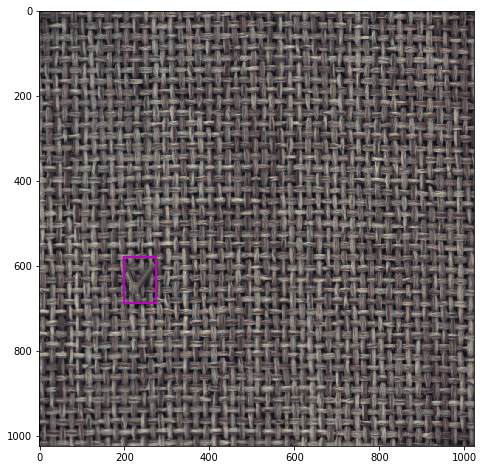

In [59]:
draw_image_and_bbox(im, bbox)

- Alright, not bad, right? 
- Let's look at a few more. 

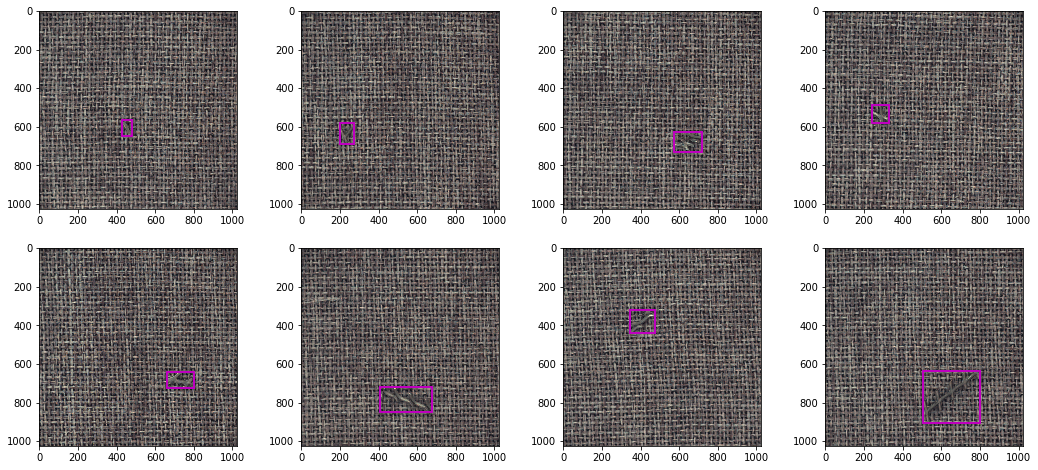

In [61]:
fig=plt.figure(0, (18,8))
for i in range(8):
    im=cv2.cvtColor(cv2.imread(str(im_paths[i])), cv2.COLOR_BGR2RGB)
    mask=cv2.imread(str(mask_paths[i]))
    bbox=mask2bbox(mask[:,:,0])
    ax=fig.add_subplot(2,4,i+1)
    draw_image_and_bbox(im, bbox, ax=ax)

## 2. Staging Data for Deep Learning Model

- So, we can visualize our data, but what about feeding it into our deep learning model?
- How do we setup our labels in a way that our model can learn from them??
- Fastai has some nice abstractions for this, we'll talk through a few of them here.

In [62]:
#Move good examples out of test dir
shutil.copytree(data_dir/dataset_name/'test'/'good', data_dir/dataset_name/'test_good')
shutil.rmtree(data_dir/dataset_name/'test'/'good')

In [63]:
from fastai.vision import *

In [64]:
image_paths=[]
lbl_bbox=[]
for c in all_classes:
    im_paths={int(p.name.split('.')[0]):p for p in (data_dir/dataset_name/'test'/c).glob('*')}
    mask_paths={int(p.name.split('_')[0]):p for p in (data_dir/dataset_name/'ground_truth'/c).glob('*')}
    for i in range(len(mask_paths)):
        image_paths.append(im_paths[i])
        mask=cv2.imread(str(mask_paths[i]))
        bbox=mask2bbox(mask[:,:,0])
        lbl_bbox.append([[bbox], [c]])

In [65]:
len(image_paths), len(lbl_bbox)

(89, 89)

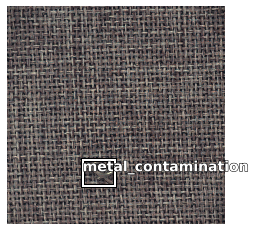

In [66]:
i=10
img = open_image(image_paths[i])
bbox=ImageBBox.create(*img.size, lbl_bbox[i][0], [0], classes=lbl_bbox[i][1])
img.show(figsize=(6,4), y=bbox)

In [67]:
img2bbox = dict(zip([str(p) for p in image_paths], lbl_bbox))
get_y_func = lambda o:img2bbox[str(o)]

In [68]:
len(img2bbox), len(image_paths), len(lbl_bbox)

(89, 89, 89)

In [69]:
src=ObjectItemList.from_folder(data_dir/dataset_name/'test')
src=src.split_by_rand_pct(0.2)

In [70]:
src.items

array([PosixPath('data/carpet/test/metal_contamination/012.png'),
       PosixPath('data/carpet/test/metal_contamination/000.png'),
       PosixPath('data/carpet/test/metal_contamination/008.png'),
       PosixPath('data/carpet/test/metal_contamination/014.png'), ..., PosixPath('data/carpet/test/cut/010.png'),
       PosixPath('data/carpet/test/cut/004.png'), PosixPath('data/carpet/test/cut/015.png'),
       PosixPath('data/carpet/test/cut/009.png')], dtype=object)

In [71]:
def get_data(bs, size):
    src = ObjectItemList.from_folder(data_dir/dataset_name/'test')
    src = src.split_by_rand_pct(0.2)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
    return src.databunch(path=data_dir/dataset_name, bs=bs, collate_fn=bb_pad_collate)

In [72]:
data=get_data(bs=64,size=256)

In [73]:
data

ImageDataBunch;

Train: LabelList (72 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: data/carpet/test;

Valid: LabelList (17 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: data/carpet/test;

Test: None

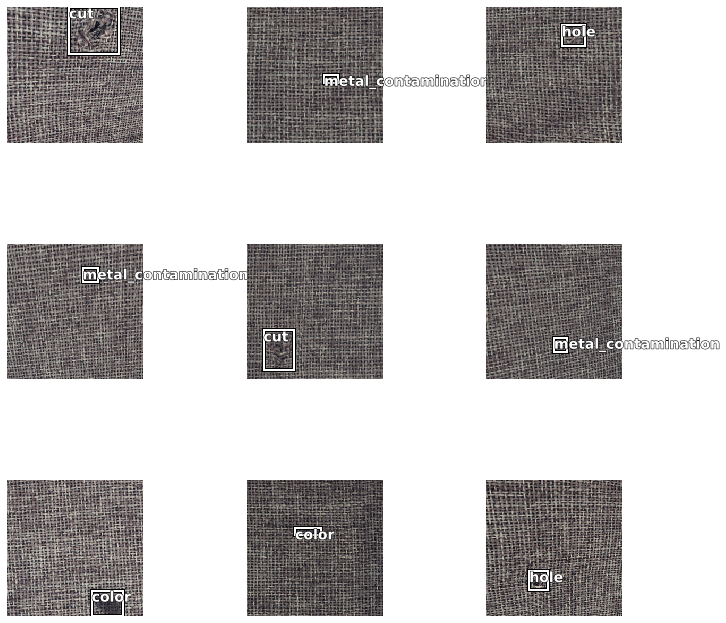

In [75]:
data.show_batch(rows=3, figsize=(10,10))

## 3. Modeling

- If you're familiar with deep learning for computer vision, you may be aware of specific neural networks architectured specifically designed for object detection, such as RCNN, YOLO, and SSD. 
- https://github.com/ultralytics/yolov3
- These networks are great options...

- Now that our dataloading pipeline is setup, let's think about what changes we need to make to our network. 
- A nice feature of fastai is the ability to easilty attach a "custom head" to a pretrained "backbone". 
- Let's start thinking about the type of output we for our object detection network. 
- Is this a Regression or Classification Problem?
- What is the Dimenion of the output we need from our neural network?

- We'll create our own custom head and loss function here
- Don't worry about the exact implementation details here too much just yet - mostly pay attention to the dimensions of the inputs and outputs!
- `AdaptiveConcatPool2d` is a really nice layer that allows us to handle input images of different sizes. 

In [76]:
custom_head = nn.Sequential(
    AdaptiveConcatPool2d((4,4)),
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16384,256), #2*512*4*4
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4))

In [77]:
class MyLoss(nn.Module):
    def forward(self, output, bbox_tgts, class_tgts):
        return nn.L1Loss()(output.unsqueeze_(dim=1), bbox_tgts)

In [78]:
learn=cnn_learner(data, models.resnet34, custom_head=custom_head, loss_func=MyLoss())

In [79]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [80]:
learn.freeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,1.586075,#na#,00:04
1,1.648307,#na#,00:04
2,1.645947,#na#,00:04
3,1.646816,#na#,00:04
4,1.646050,#na#,00:04
5,1.661822,#na#,00:04
6,1.650843,#na#,00:04
7,1.625414,#na#,00:04
8,1.631262,#na#,00:04
9,1.630333,#na#,00:04


In [ ]:
learn.recorder.plot()

In [ ]:
learn.save('object-detector-1')

In [58]:
lr=1e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,time
0,0.900297,1.472769,00:03
1,0.911111,1.174036,00:03
2,0.865477,1.011207,00:03
3,0.857558,0.907320,00:03


In [59]:
lr=1e-2
learn.fit_one_cycle(12, lr)

epoch,train_loss,valid_loss,time
0,0.883197,0.839468,00:03
1,0.885044,0.783931,00:03
2,0.869059,0.742572,00:03
3,0.857368,0.686093,00:03
4,0.833849,0.596194,00:03
5,0.830558,0.576257,00:03
6,0.807649,0.574132,00:03
7,0.786865,0.574317,00:03
8,0.764530,0.570791,00:03
9,0.747298,0.566638,00:03


In [60]:
learn.save('object-detector-1')

In [61]:
lr=1e-2
learn.fit_one_cycle(12, lr)

epoch,train_loss,valid_loss,time
0,0.630470,0.544274,00:03
1,0.619000,0.534174,00:03
2,0.626642,0.510970,00:03
3,0.614684,0.507304,00:03
4,0.612076,0.501330,00:03
5,0.591789,0.491308,00:03
6,0.582465,0.473828,00:03
7,0.574071,0.462418,00:03
8,0.566498,0.450547,00:03
9,0.559420,0.439387,00:03


In [ ]:
learn.save('object-detector-1')

In [62]:
lr=1e-2
learn.fit_one_cycle(12, lr)

epoch,train_loss,valid_loss,time
0,0.525199,0.417707,00:03
1,0.515083,0.402447,00:03
2,0.515154,0.384826,00:03
3,0.513875,0.379659,00:03
4,0.512114,0.374790,00:03
5,0.509786,0.379433,00:03
6,0.504400,0.382482,00:03
7,0.496658,0.383203,00:03
8,0.496304,0.383425,00:03
9,0.494668,0.383203,00:03


In [ ]:
learn.save('object-detector-1')

In [63]:
lr=1e-2
learn.fit_one_cycle(12, lr)

epoch,train_loss,valid_loss,time
0,0.449666,0.383039,00:03
1,0.441038,0.384603,00:03
2,0.450714,0.395623,00:03
3,0.449134,0.423175,00:03
4,0.438521,0.436988,00:03
5,0.439157,0.440067,00:03
6,0.443078,0.435421,00:03
7,0.440081,0.428594,00:03
8,0.433298,0.425364,00:03
9,0.426980,0.422900,00:03


In [64]:
learn.unfreeze()

In [65]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.415465,#na#,00:03
1,0.397459,#na#,00:02
2,0.417282,#na#,00:02
3,0.419467,#na#,00:02
4,0.414982,#na#,00:02
5,0.409300,#na#,00:02
6,0.409878,#na#,00:02
7,0.409824,#na#,00:02
8,0.409042,#na#,00:02
9,0.410942,#na#,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


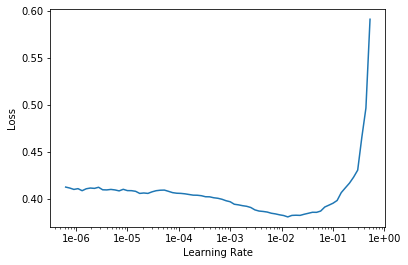

In [66]:
learn.recorder.plot()

In [67]:
lr=1e-3
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,0.419517,0.423845,00:03
1,0.397570,0.403635,00:03
2,0.409138,0.380328,00:03
3,0.414322,0.395672,00:03
4,0.415076,0.414018,00:03
5,0.416024,0.431137,00:03
6,0.415988,0.438343,00:03
7,0.410084,0.436000,00:03


In [68]:
lr=1e-2
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,0.408026,0.451684,00:03
1,0.378118,0.552004,00:03
2,0.381424,1.719093,00:03
3,0.387361,3.873881,00:03
4,0.388268,10.409428,00:03
5,0.384209,11.255696,00:03
6,0.382403,5.054204,00:03
7,0.380936,2.991342,00:03


In [69]:
learn.load('object-detector-1')

Learner(data=ImageDataBunch;

Train: LabelList (96 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: data/screw/test;

Valid: LabelList (23 items)
x: ObjectItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ObjectCategoryList
ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256),ImageBBox (256, 256)
Path: data/screw/test;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlo

In [70]:
lr=1e-3
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,time
0,0.633510,0.544749,00:03
1,0.614055,0.517790,00:03
2,0.604128,0.487111,00:03
3,0.599086,0.468615,00:03
4,0.602586,0.491938,00:03
5,0.598989,0.488704,00:03
6,0.604092,0.483596,00:03
7,0.604684,0.476849,00:03


## 4. Visualize Results

In [71]:
def compute_corner_locations(y, im_shape=(256,256)):
    shape_vec=np.array(im_shape*2)
    bounds=((y+1)*shape_vec/2).ravel()
    corners=np.array([[bounds[1], bounds[0]], 
                      [bounds[3], bounds[0]],
                      [bounds[3], bounds[2]],
                      [bounds[1], bounds[2]],
                      [bounds[1], bounds[0]]])
    return corners

In [72]:
x,y = next(iter(learn.data.valid_dl))
with torch.no_grad():
    yhat = learn.model(x.to('cuda'))

In [73]:
x.shape, y[0].shape, yhat.shape

(torch.Size([23, 3, 256, 256]), torch.Size([23, 1, 4]), torch.Size([23, 4]))

In [74]:
#Reshape image block and convert to numpy for visualization: 
x_numpy=np.moveaxis(x.cpu().numpy(), (0, 2, 3, 1), (0, 1, 2, 3))

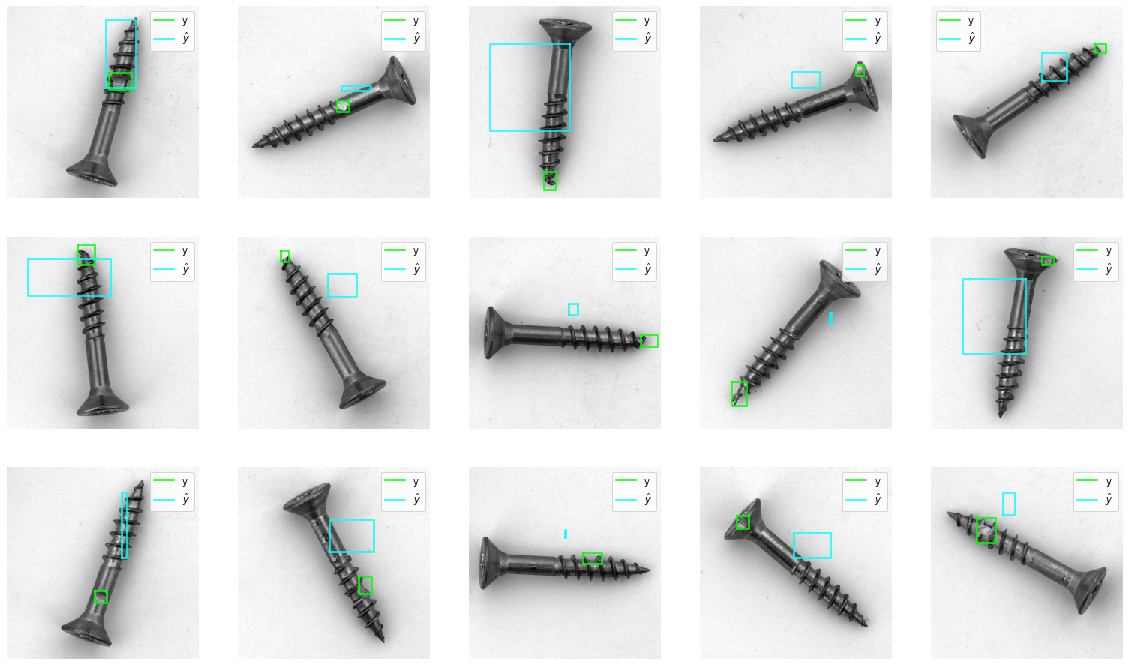

In [76]:
fig=plt.figure(0, (20,12))
for i in range(15): 
    fig.add_subplot(3,5,i+1)
    plt.imshow(x_numpy[i].mean(axis=2), cmap='gray')
    
    corners=compute_corner_locations(y[0][i].cpu().numpy())
    plt.plot(corners[:, 0], corners[:,1], c=(0, 1, 0))
    
    corners=compute_corner_locations(yhat[i].cpu().numpy())
    plt.plot(corners[:, 0], corners[:,1], c=(0, 1, 1))
    plt.axis('off')
    plt.legend(['y', '$\hat{y}$'])

- Not bad, right!?
- Now, there's a lot more to object detection - there's lots of ways to further improve on the performance we're achieving here. More importantly, we haven't solved object detection in the general case. **Why not?**
- This issue here is that we have no way for our algorithm to detect multple objects in the same image!
- There's alot that goes into handling multiple objects in the same image - the [SSD](https://arxiv.org/pdf/1512.02325.pdf), [Yolo](https://arxiv.org/pdf/1506.02640.pdf), and [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) papers are a great place to start learning about more sophisticated appraoches. 